In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparsePCA, PCA
from sklearn import linear_model
from tqdm import tqdm


# Regression and PCA analysis of $Z_{C,P}$ trends

As a reminder, the nominal oxidation state of C atoms in all proteins (the "proteome") is a carbon average of the $Z_C$ values of individual proteins: 

$Z_{C,P} = \frac{ \sum_i  Z_{C,i} \cdot N_{C,i} \cdot \eta_i }{\sum_i N_{C,i} \cdot \eta_i }$

where $\eta_i$ is the relative level of protein $i$. 

By defining little 

$z_j = \frac{Z_{C,j} \cdot N_{C,j} \cdot \eta_j }{\sum_i N_{C,i} \cdot \eta_i }$

we notice that $Z_{C,P} = \sum_j z_j$. That is, in any condition $Z_{C,P}$ is a linear function of the $z_j$ values. Therefore, if we regress condition-dependent $Z_C,P$ values against $z_j$ we should be able to perfectly reconstruct $Z_C,P$ changes. 

Moreover, since the expression levels $\eta_j$ are correlated with each other &mdash; e.g., ribosomal proteins are expressed at similar levels &mdash; we won't need all the little $z_j$ values. Here we use sparse regression (the lasso) to ask how many "basis proteins" are needed to predict 100% of variation in $Z_{C,P}$ as a means of understanding the intrinsic dimensionality of the trend. We then ask whether these basis proteins represent a wide or narrow diversity of biological functions using the COG taxonomy. 

# Cut? 

Later in the notebook we also apply PCA. The above-described lasso regression approach is distinct from PCA/SVD since it requires each basis vector to be composed of a single protein, rather than forming an orthogonal basis out of a linear combination of features (proteins) as in PCA. While PCA might tell us that the $Z_{C,P}$ trend can be explained by 1-3 dimensions, these dimensions might be composed of a wide variety of co-varying proteins. Lasso instead asks -- how many groups of correlated proteins are needed to explain the $Z_{C,P}$ trend across some dataset. 

In [2]:
# Load all the expression data
all_exp_df = pd.read_csv('../data/proteomes/all_protein_measurements.csv')

# All the yeast data
mask = all_exp_df.organism_key == 'yeast'
yeast_exp_df = all_exp_df[mask]

# All the cyanobacterial data
mask = all_exp_df.organism_key == 'PCC6803'
cyano_exp_df = all_exp_df[mask]

# All the E. coli data
mask = all_exp_df.organism_key == 'coli'
coli_exp_df = all_exp_df[mask]

# Focus on Schmidt dataset for E. coli analysis. 
mask = all_exp_df.dataset == 'schmidt_2016'
schmidt_df = all_exp_df[mask]

# Separate chemostat and batch (nonstress) data
mask = np.logical_and(schmidt_df.growth_mode == 'chemostat', schmidt_df.stress == False)
schmidt_chemo_df = schmidt_df[mask]

mask = np.logical_and(schmidt_df.growth_mode == 'batch', schmidt_df.stress == False)
schmidt_batch_df = schmidt_df[mask]

# grab all the non-stress conditions
mask = schmidt_df.stress == False
schmidt_nonstress_df = schmidt_df[mask]

# Read in condition-wise Z_C,P values
coli_NOSC_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
yeast_NOSC_data = pd.read_csv('../data/proteomes/Scer/Xia_proteome_NOSC.csv')
cyano_NOSC_data = pd.read_csv('../data/proteomes/Synechocystis/Zavrel_proteome_NOSC.csv')

# Read in coli genome information
all_CDS_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')
coli_CDS_df = all_CDS_df[all_CDS_df.organism == 'coli']
yeast_CDS_df = all_CDS_df[all_CDS_df.organism == 'yeast']
cyano_CDS_df = all_CDS_df[all_CDS_df.organism == 'PCC6803']

/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
def _make_mat_Ce_normed(long_df, protein_id='b_number', index_cols=('dataset', 'condition', 'growth_rate_hr')):
    """Convert long-form expression data to matrices of Z_C,P contributions z_j.

    See notes at the top for definition of z_j. 

    Args:
        long_df (pd.DataFrame): Long-form expression data with columns
            'b_number,dataset,condition,growth_rate_hr,Ce_total,NC_total'.
    
    Returns:
        mat_Ce_normd (pd.DataFrame): Matrix of z_j values for each protein j. 
            Rows are proteins, columns are conditions.
    """
    # Mask out entries with missing values
    mask = np.logical_or(long_df.Ce_total.notnull(), long_df.NC_total.notnull())
    
    # Calculate each proteins' z_j value in each condition. 
    # Note: Ce_total = N_C*copies_per_cell*Z_C
    # and NC_total = N_C*copies_per_cell
    mat_Ce_tot = long_df[mask].pivot_table(index=protein_id, 
                                           values='Ce_total', columns=index_cols)
    mat_NC_tot = long_df[mask].pivot_table(index=protein_id, values='NC_total', columns=index_cols)

    # Normalize by total protein C content
    mat_Ce_normd = mat_Ce_tot / mat_NC_tot.sum()
    return mat_Ce_normd.replace({np.NaN: 0})


def _do_sparse_regression(A_mat, b_resp, alpha, max_iter=100000):
    """Do sparse regression with Lasso regularization.

    Args:
        A_mat (np.ndarray): Matrix of predictors.
        b_resp (np.ndarray): Vector of responses.
        alpha (float): Regularization parameter.
        max_iter (int): Maximum number of iterations for Lasso regression.

    Returns:
        dict: Dictionary of results with keys 'number_nonzero', 'r2', and 'alpha'.
    """
    # Requiring positive contributions since proteins contributions to Z_C,P are strictly positive.
    # Not fitting an intercept since the chemical relationship has 0 intercept.
    reg = linear_model.Lasso(alpha=alpha, max_iter=max_iter,
                             fit_intercept=False, positive=True)
    reg.fit(A_mat, b_resp)

    # Get number of nonzero coefficients and R^2
    nz_coeff = reg.coef_[reg.coef_ != 0]
    r2 = reg.score(A_mat, b_resp)
    return dict(number_nonzero=nz_coeff.size, r2=r2, alpha=alpha)

In [4]:
# E. coli analysis
# Consider fitting just the chemostat conds, just the batch conds, and both together.
mat_schmidt_chemo = _make_mat_Ce_normed(schmidt_chemo_df)
mat_schmidt_batch = _make_mat_Ce_normed(schmidt_batch_df)
mat_schmidt_nonstress = _make_mat_Ce_normed(schmidt_nonstress_df)
mat_coli_all = _make_mat_Ce_normed(coli_exp_df)

# Perform and plot predictive accuracy of sparse regression for different levels of sparsity.
# Response variable is the whole proteome Z_C,P for the appropriate conditions
coli_NOSC_reindexed = coli_NOSC_data.set_index('dataset,condition,growth_rate_hr'.split(','))
b_chemo = coli_NOSC_reindexed.loc[mat_schmidt_chemo.columns].proteome_NOSC
b_batch = coli_NOSC_reindexed.loc[mat_schmidt_batch.columns].proteome_NOSC
b_nonstress = coli_NOSC_reindexed.loc[mat_schmidt_nonstress.columns].proteome_NOSC
b_coli_all = coli_NOSC_reindexed.loc[mat_coli_all.columns].proteome_NOSC

# Regressed against individual contributions of proteins in the matrices above. 
A_chemo = mat_schmidt_chemo.T
A_batch = mat_schmidt_batch.T
A_nonstress = mat_schmidt_nonstress.T
A_coli_all = mat_coli_all.T
coli_A_mats = [(A_chemo, b_chemo, 'chemostat'),
               (A_batch, b_batch, 'batch'),
               (A_nonstress, b_nonstress, 'both'),
               (A_coli_all, b_coli_all, 'all')]

# Test different regularization parameters. Larger alpha => sparser models.
n_alphas = 50
alphas = np.logspace(-6, -9, n_alphas)
res_ds = []

for alpha in tqdm(alphas):
    for A_mat, b_resp, cond in coli_A_mats:
        d = _do_sparse_regression(A_mat, b_resp, alpha)
        d['conditions_included'] = cond
        d['organism_key'] = 'coli'
        res_ds.append(d)

# Make and save a dataframe with the summary of this analysis.
coli_reg_df = pd.DataFrame(res_ds)
coli_reg_df.to_csv('../data/proteomes/Coli/Schmidt_lasso_regression.csv', index=False)

100%|██████████| 50/50 [02:12<00:00,  2.65s/it]


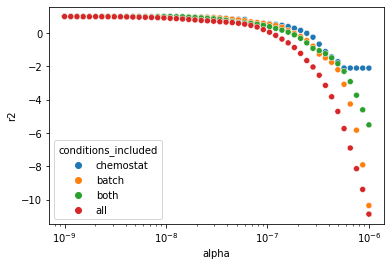

In [5]:
# What alpha should we use for E. coli? Looks like 1e-8 is great for all conds
plt.figure()
plt.xscale('log')
sns.scatterplot(data=coli_reg_df, x='alpha', y='r2', hue='conditions_included')
plt.show()

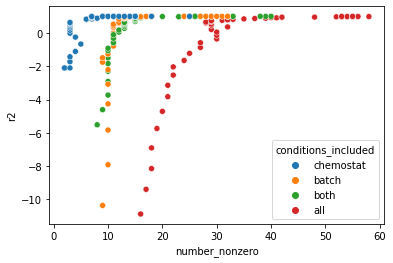

In [6]:
# What alpha should we use for E. coli? Looks like 1e-8 is great for all conds
plt.figure()
sns.scatterplot(data=coli_reg_df, x='number_nonzero', y='r2', hue='conditions_included')
plt.show()

In [7]:
# Yeast analysis
mat_yeast_all = _make_mat_Ce_normed(yeast_exp_df, protein_id='majority_protein_ids')

# Perform and plot predictive accuracy of sparse regression for different levels of sparsity.
# Response variable is the whole proteome Z_C,P for the appropriate conditions
yeast_NOSC_reindexed = yeast_NOSC_data.set_index('growth_rate_hr')
b_yeast_all = yeast_NOSC_reindexed.loc[mat_yeast_all.columns.levels[2]].proteome_NOSC

# Regressed against individual contributions of proteins in the matrices above. 
A_yeast_all = mat_yeast_all.T

# Test different regularization parameters. Larger alpha => sparser models.
res_ds = []
for alpha in tqdm(alphas):
    d = _do_sparse_regression(A_yeast_all, b_yeast_all, alpha)
    d['conditions_included'] = 'chemostat'
    d['organism_key'] = 'yeast'
    res_ds.append(d)

# Make and save a dataframe with the summary of this analysis.
yeast_reg_df = pd.DataFrame(res_ds)
yeast_reg_df.to_csv('../data/proteomes/Scer/Xia_lasso_regression.csv', index=False)

100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


In [8]:
# Cyano analysis
mat_cyano_all = _make_mat_Ce_normed(cyano_exp_df, protein_id='majority_protein_ids')

# Perform and plot predictive accuracy of sparse regression for different levels of sparsity.
# Response variable is the whole proteome Z_C,P for the appropriate conditions
cyano_NOSC_reindexed = cyano_NOSC_data.set_index('growth_rate_hr')
b_cyano_all = cyano_NOSC_reindexed.loc[mat_cyano_all.columns.levels[2]].proteome_NOSC
b_cyano_all = b_cyano_all[b_cyano_all.notnull()].copy()

# Regressed against individual contributions of proteins in the matrices above. 
A_cyano_all = mat_cyano_all.T

# Test different regularization parameters. Larger alpha => sparser models.
res_ds = []
for alpha in tqdm(alphas):
    d = _do_sparse_regression(A_cyano_all, b_cyano_all, alpha)
    d['conditions_included'] = 'chemostat'
    d['organism_key'] = 'PCC6803'
    res_ds.append(d)

# Make and save a dataframe with the summary of this analysis.
cyano_reg_df = pd.DataFrame(res_ds)
cyano_reg_df.to_csv('../data/proteomes/Synechocystis/Zavrel_lasso_regression.csv', index=False)

100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


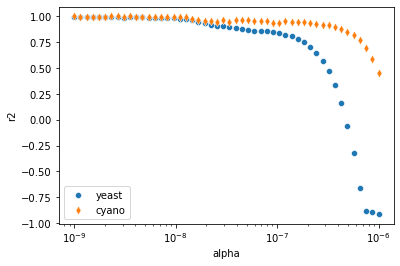

In [9]:
# What alpha should we use? Looks like 1e-8 is great for cyano, 1e-9 for yeast
plt.figure()
plt.xscale('log')
sns.scatterplot(data=yeast_reg_df, x='alpha', y='r2', label='yeast')
sns.scatterplot(data=cyano_reg_df, x='alpha', y='r2', label='cyano', marker='d')
plt.show()

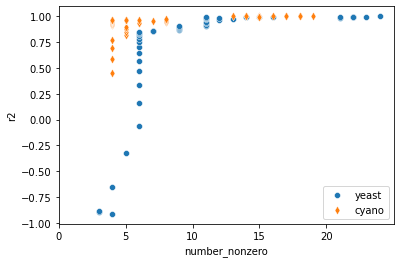

In [10]:
# What alpha should we use? Looks like 1e-8 is great for cyano, 1e-9 for yeast
plt.figure()
sns.scatterplot(data=yeast_reg_df, x='number_nonzero', y='r2', label='yeast')
sns.scatterplot(data=cyano_reg_df, x='number_nonzero', y='r2', label='cyano', marker='d')
plt.xticks(np.arange(0, 25, 5))
plt.show()

In [11]:
# Merge into a single dataframe for plots
long_reg_df = pd.concat([coli_reg_df, yeast_reg_df, cyano_reg_df])
long_reg_df.to_csv('../data/proteomes/all_lasso_regression.csv', index=False)


In [12]:
def _regress_and_count_nz_cogs(A_mat, b_resp, alpha, cds_df, protein_id='b_number'):
    """Perform sparse regression and count the COG categories of the proteins with nonzero coefficients.

    Args:
        A_mat (pd.DataFrame): Matrix of predictors.
        b_resp (pd.Series): Vector of responses.
        alpha (float): Regularization parameter.
        cds_df (pd.DataFrame): Dataframe with COG categories for each protein.
        protein_id (str): Name of the column in cds_df with the protein IDs.

    Returns:
        tuple: Tuple of (R^2, list of proteins with nonzero coefficients,
            pandas Series of COG categories and their counts).
    """
    reg = linear_model.Lasso(alpha=alpha, max_iter=100000, fit_intercept=False, positive=True)
    reg.fit(A_mat, b_resp)

    r2 = reg.score(A_mat, b_resp)
    
    nz_prots = A_mat.columns[np.where(reg.coef_ != 0)].values
    nz_prot_meta = cds_df.set_index(protein_id).loc[nz_prots]

    cats = nz_prot_meta.primary_COG_category.value_counts()
    return r2, nz_prots, cats

In [13]:
# Setting regularization alpha to 1e-8, we ask now what types of proteins are selected.
# This is done on the basis of their primary COG categories, which are high-level functional description
COG_cats = pd.read_csv('../data/COG-fun-20.csv').set_index('category')

alpha = 1e-8
print('alpha = {0}'.format(alpha))

# Append organism name to each tuple. 
# Omitting yeast from the COG analysis because the COG DB is for prokaryotes only.
tmp_coli_mats = [(*c, 'coli') for c in coli_A_mats]
all_mats = tmp_coli_mats + [(A_cyano_all, b_cyano_all, 'chemostat', 'PCC6803')]

cat_counts_template = pd.Series(dict((i, 0) for i in COG_cats.index))
cols = []
index_names = []

cds_dfs = dict(coli=coli_CDS_df, yeast=yeast_CDS_df, PCC6803=cyano_CDS_df)
protein_ids = dict(coli='b_number', yeast='primary_accession', PCC6803='primary_accession')

for A_mat, b_resp, cond, organism in all_mats: 
    print(organism, cond)
    p_id = protein_ids[organism]
    cds_df = cds_dfs[organism]
    r2, nz_prots, cats = _regress_and_count_nz_cogs(A_mat, b_resp, alpha, cds_df, protein_id=p_id)
    print('{0} {1}: r2 = {2:.2f}'.format(organism, cond, r2))
    
    cat_counts_column = cat_counts_template.copy()
    cat_counts_column[cats.index] = cats
    cols.append(cat_counts_column)
    index_names.append('{0}_{1}'.format(organism, cond))


alpha = 1e-08
coli chemostat
coli chemostat: r2 = 1.00
coli batch
coli batch: r2 = 0.99
coli both
coli both: r2 = 0.99
coli all
coli all: r2 = 0.90
PCC6803 chemostat
PCC6803 chemostat: r2 = 1.00


In [33]:
# Cyano regression does pretty well with only 5-6 proteins -- what are those? 
my_alpha = 1e-7
r2, nz_prots, cats = _regress_and_count_nz_cogs(A_cyano_all, b_cyano_all, my_alpha, cyano_CDS_df, protein_id='primary_accession')

print(r2)
print(nz_prots)
cyano_CDS_df.set_index('primary_accession').loc[nz_prots]['description,KEGG_pathways'.split(',')]

0.9346976795271461
['P29254' 'P29255' 'P74227' 'Q01951' 'Q01952' 'Q05972']


,description,KEGG_pathways
primary_accession,,
P29254,Photosystem I P700 chlorophyll a apoprotein A1,"Photosynthesis - Synechocystis sp. PCC 6803,Me..."
P29255,Photosystem I P700 chlorophyll a apoprotein A2,"Photosynthesis - Synechocystis sp. PCC 6803,Me..."
P74227,Elongation factor Tu,NaN
Q01951,Allophycocyanin alpha chain,Photosynthesis - antenna proteins - Synechocys...
Q01952,Allophycocyanin beta chain,Photosynthesis - antenna proteins - Synechocys...
Q05972,Chaperonin GroEL 1,RNA degradation - Synechocystis sp. PCC 6803


In [16]:
cat_counts_df = pd.DataFrame(cols, index=index_names)
cat_counts_df.to_csv('../data/proteomes/lasso_regression_COG_counts_alpha={0:.2g}.csv'.format(alpha))

In [17]:
long_cat_counts_df = cat_counts_df.reset_index().melt(
    id_vars='index', var_name='COG_category', value_name='number_proteins').rename({'index': 'organism_condition'}, axis=1)
long_cat_counts_df.to_csv('../data/proteomes/long_lasso_regression_COG_counts_alpha={0:.2g}.csv'.format(alpha), index=False)

3 ['coli_chemostat', 'coli_batch', 'PCC6803_chemostat']


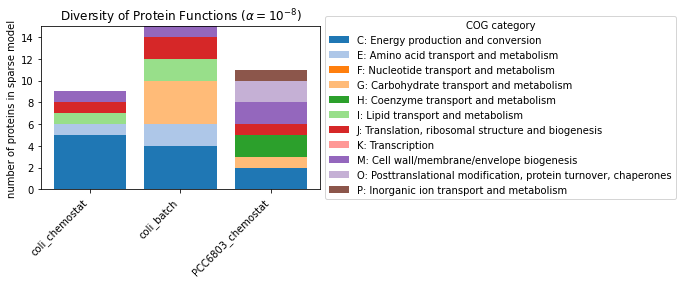

In [18]:
plt.figure(figsize=(5,3))
pal = sns.color_palette('tab20')
j = 0
# Consider only the bacteria since the eukaryotes don't get COG categories
conds = 'coli_chemostat,coli_batch,PCC6803_chemostat'.split(',')
n_conds = len(conds)
print(n_conds, conds)

bottom = np.zeros(n_conds)
xs = np.arange(n_conds)
for i, cat in enumerate(sorted(cat_counts_template.index)):
    cat_desc = COG_cats.loc[cat].description
    masked = long_cat_counts_df[long_cat_counts_df.COG_category == cat].set_index('organism_condition')
    if masked.number_proteins.sum() == 0:
        continue

    ys = masked.loc[conds].number_proteins.values
    label = '{0}: {1}'.format(cat, cat_desc)
    plt.bar(xs, ys, bottom=bottom, color=pal[j], label=label)
    bottom += ys
    j += 1

plt.xticks(xs, conds, rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='COG category')
plt.ylabel('number of proteins in sparse model')
plt.title('Diversity of Protein Functions ($\\alpha = 10^{-8}$)')
plt.show()


(159, 48)


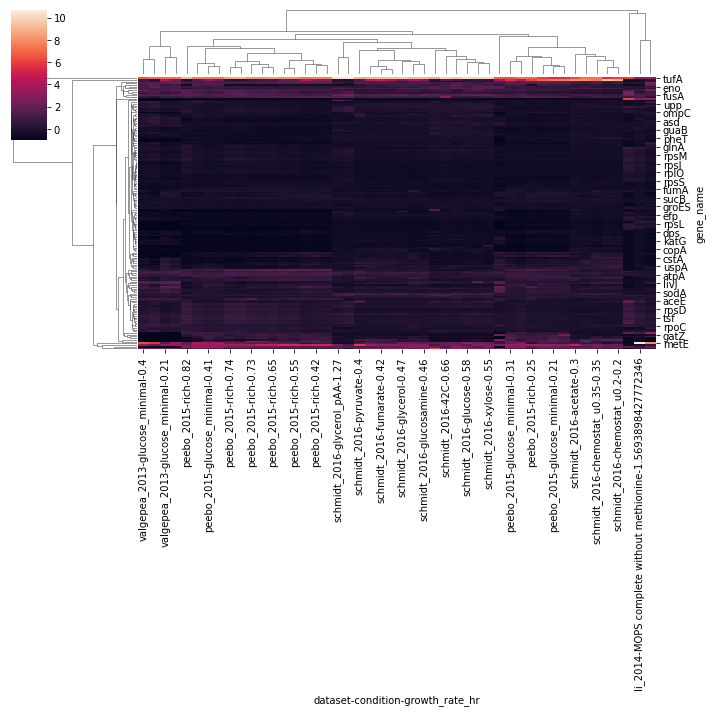

In [19]:
# Biclustering and genes and conditions by their contribution to ZCP
# Ditch the rows containing zero values, which where previously NaN
rows_in_all = (mat_coli_all != 0).all(axis=1).index
sub_mat = mat_coli_all.loc[rows_in_all]

# Index by gene name for readability
sub_mat['gene_name'] = coli_CDS_df.set_index('b_number').loc[sub_mat.index].gene_name
sub_mat.set_index('gene_name', inplace=True)

# Mask out the genes that don't vary as much, otherwise it's all zeros
mask = sub_mat.std(axis=1) > 1e-4

# Clustermap of the negative contribution to ZCP since the contributions are mostly negative
sns.clustermap(data=-sub_mat[mask], z_score=1)

# We are considering ≈150 genes here.
print(sub_mat[mask].shape)

In [20]:
# Read in the sequence information for E. coli
coli_nosc_df = pd.read_csv('../data/genomes/Coli/MG1655/MG1655_ref_prot_NOSC.csv').set_index('b_number')

# Read in matching proteomics
coli_expression_df = pd.read_csv('../data/proteomes/Coli/Chure_mean_absolute_measurements.csv')

# Sum the total measured mass per condition.
mass_totals = coli_expression_df.groupby('condition').sum()['fg_per_cell']
per_entry_mass_total = mass_totals.loc[coli_expression_df.condition].values

# Calculate the relative mass, i.e. the fraction of measured mass associated with this protein.
coli_expression_df['rel_mass'] = coli_expression_df.fg_per_cell / per_entry_mass_total

# Read in condition-wise Z_C,P values
coli_NOSC_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')

# Take only the Schmidt 2016 chemostat data for the initial analysis
mask = np.logical_and(coli_expression_df.dataset == 'schmidt_2016',
                      coli_expression_df.condition.str.startswith('chemo'))
coli_chemostat_exp_df = coli_expression_df[mask].reset_index().drop('index', axis=1).copy()
coli_chemostat_exp_df.head()


,b_number,dataset,strain,condition,growth_rate_hr,copies_per_cell,fg_per_cell,NOSC,NC_per,num_aas,...,species,majority_protein_ids,fraction_transmembrane,fraction_transmembrane_C,growth_mode,stress,Ce_per,Ce_total,NC_total,rel_mass
0,b3448,schmidt_2016,BW25113,chemostat_u0.12,0.12,182.004991,0.005023,-0.031204,706.0,146,...,E. coli,P0ADX7,0.000000,0.000000,chemostat,False,-22.03,-4009.569943,128495.523358,0.000033
1,b3448,schmidt_2016,BW25113,chemostat_u0.2,0.20,137.023553,0.003781,-0.031204,706.0,146,...,E. coli,P0ADX7,0.000000,0.000000,chemostat,False,-22.03,-3018.628866,96738.628197,0.000023
2,b3448,schmidt_2016,BW25113,chemostat_u0.35,0.35,141.887995,0.003916,-0.031204,706.0,146,...,E. coli,P0ADX7,0.000000,0.000000,chemostat,False,-22.03,-3125.792538,100172.924724,0.000021
3,b3448,schmidt_2016,BW25113,chemostat_u0.5,0.50,94.579432,0.002610,-0.031204,706.0,146,...,E. coli,P0ADX7,0.000000,0.000000,chemostat,False,-22.03,-2083.584881,66773.078787,0.000012
4,b1631,schmidt_2016,BW25113,chemostat_u0.12,0.12,36.969764,0.001345,-0.143690,973.0,206,...,E. coli,P77285,0.097087,0.097087,chemostat,False,-139.81,-5168.742665,35971.580094,0.000009


In [21]:
coli_expression_df[coli_expression_df.dataset == 'schmidt_2016'].condition.unique()

# Enumerating the non-stress conditions in Schmidt et al.
conds = ['acetate', 'chemostat_u0.12', 'chemostat_u0.2',
       'chemostat_u0.35', 'chemostat_u0.5', 'fructose', 'fumarate',
       'galactose', 'glucosamine', 'glucose', 'glycerol', 'glycerol_pAA',
       'lb_miller', 'mannose', 'pyruvate', 'succinate', 'xylose']
mask = np.logical_and(coli_expression_df.dataset == 'schmidt_2016',
                      coli_expression_df.condition.isin(conds))
coli_nonstress_exp_df = coli_expression_df[mask].reset_index().drop('index', axis=1).copy()

In [22]:
index_cols = 'condition,growth_rate_hr'.split(',')
mask = np.logical_or(coli_nonstress_exp_df.Ce_total.notnull(), coli_nonstress_exp_df.NC_total.notnull())

# Calculate each proteins' contribution to proteome Z_C in
# each condition by taking the ratio Ce_total/NC_total where 
# Ce_total = tot_per_cell*NC*NOSC and NC_total = tot_per_cell*NC
mat_Ce_tot = coli_nonstress_exp_df[mask].pivot_table(index='b_number', values='Ce_total', columns=index_cols)
mat_NC_tot = coli_nonstress_exp_df[mask].pivot_table(index='b_number', values='NC_total', columns=index_cols)

# The sign of principal component loadings are confusing here because 
# Ce_total and Z_C values are almost uniformly negative. Could potentially
# invert here, but instead we'll just look for large absolute loadings. 
mat_Ce_normd = mat_Ce_tot / mat_NC_tot.sum()
mat_Ce_normd = mat_Ce_normd.replace({np.NaN: 0})
fit_pca = PCA(n_components=3).fit(mat_Ce_normd.T)
# blame_i = NOSC*NC*x_i / (sum_i (NC*x_i))

# First component explains about 96% of the variation in the Schmidt chemostat conds. 
pct_var = fit_pca.explained_variance_ratio_*100
print('Fit PC1 "explains" {0:.2f}% of Z_C variation'.format(pct_var[0]))
print('Fit PC2 "explains" {0:.2f}% of Z_C variation'.format(pct_var[1]))
print('Fit PC3 "explains" {0:.2f}% of Z_C variation'.format(pct_var[2]))

Fit PC1 "explains" 68.18% of Z_C variation
Fit PC2 "explains" 12.27% of Z_C variation
Fit PC3 "explains" 7.22% of Z_C variation


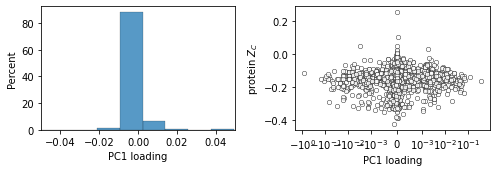

In [23]:
# Peek at the first component loadings
loadings = fit_pca.components_
first_comp = loadings[0,:]

fig, axs = plt.subplots(ncols=2, figsize=(7,2.5))
plt.sca(axs[0])
sns.histplot(first_comp, bins=100, stat="percent")
plt.xlabel('PC1 loading')
plt.xlim(-0.05, 0.05)

plt.sca(axs[1])
NOSC = coli_nosc_df.loc[mat_Ce_tot.index].NOSC
plt.xscale('symlog', linthresh=0.001)
plt.scatter(first_comp, NOSC, s=20, color='w', edgecolors='k', lw=0.5, alpha=0.8)
plt.ylabel('protein $Z_C$')
plt.xlabel('PC1 loading')

plt.tight_layout()
plt.show()

In [24]:
expressed_genes_nosc = coli_nosc_df.loc[mat_Ce_normd.index].copy()
expressed_genes_nosc['PC1 loading'] = first_comp
expressed_genes_nosc['PC2 loading'] = loadings[1,:]
expressed_genes_nosc.to_csv('coli_nonstress_PCA_loadings.csv')

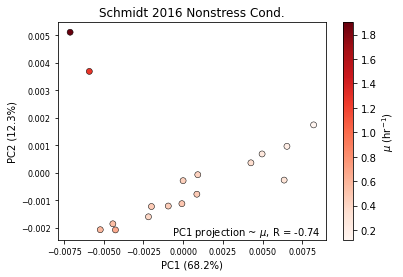

In [25]:
# PC1 of NOSC data correlates well with growth rate. 
# qn: is this just that expression correlates with growth? 
# can compare to expression only and see if this improves things. 
conds_proj = fit_pca.transform(mat_Ce_normd.T)
gr_dict = dict(mat_Ce_normd.columns)
grs = [gr for k,gr in mat_Ce_normd.columns]

pearson_r = np.corrcoef(conds_proj[:,0], grs)[0,1]

cmap = sns.color_palette('Reds', as_cmap=True)
plt.figure()
plt.scatter(conds_proj[:,0], conds_proj[:,1], c=grs, edgecolor='k', lw=0.5, cmap=cmap)
plt.xlabel('PC1 ({0:.1f}%)'.format(fit_pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 ({0:.1f}%)'.format(fit_pca.explained_variance_ratio_[1]*100))
plt.colorbar(label='$\mu$ (hr$^{-1}$)')
plt.text(0.98, 0.02, 'PC1 projection ~ $\mu$, R = {0:.2f}'.format(pearson_r),
         transform=plt.gca().transAxes, ha='right')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Schmidt 2016 Nonstress Cond.')
plt.savefig('../output/all_coli_PCA_projection.png', facecolor='w', dpi=300)
plt.show()

alpha = 1e-06 = 10^-6
8 nonzero terms
Coefficients: [10.41722424  4.90561912  7.62991983  1.52063842  2.30477692  7.68848549
  2.35071273  1.51689215]
alpha = 1e-07 = 10^-7
14 nonzero terms
Coefficients: [1.07286350e+01 7.59387225e+00 6.73761067e+00 1.22827587e+00
 1.51677564e-02 9.32615141e-01 3.32524534e+00 6.00613144e+00
 3.90187619e+00 4.15602866e+00 1.88657549e-01 3.98717138e-03
 7.17013766e+00 7.40974421e-01]
alpha = 1e-08 = 10^-8
18 nonzero terms
Coefficients: [1.73833596e+01 1.05997027e+01 6.49460046e-01 1.09089878e+01
 1.05897709e+00 1.79699129e+00 1.15567715e+00 5.24066259e+00
 8.21243782e+00 4.14419437e+00 2.35333079e-03 2.43426004e+00
 3.04604144e+00 1.57765805e+00 1.30407998e+00 1.08890197e-01
 5.54401698e-02 4.44901060e+00]
alpha = 1e-09 = 10^-9
38 nonzero terms
Coefficients: [2.33663178e+01 6.62878596e+01 3.72279934e+01 6.59763963e+00
 3.33449584e+00 6.73477440e+00 2.50823086e+00 4.81829913e+00
 1.58985738e+01 6.75250187e-01 3.09957249e+01 1.60048111e+01
 3.05636790e-01 

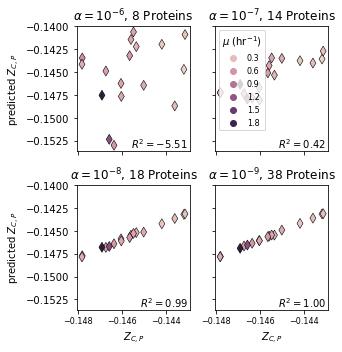

In [26]:
# Perform and plot predictive accuracy Sparse regression for different levels of sparsity.
# Response variable is the whole proteome Z_C,P
schmidt_data = coli_NOSC_data[coli_NOSC_data.dataset == 'schmidt_2016'].set_index('condition')
b = schmidt_data.loc[mat_Ce_normd.columns.levels[0]].proteome_NOSC

# Regressed against individual contributions of proteins. 
# Obviously we can predict b from A because b is a linear combination of the entries
# of A by the definition of Z_C. However this analysis asks how well b can be predicted
# from a small subset of the entries in A by altering the sparsity parameter alpha 
# of a Lasso-style regression. The result is that you only need ~10 proteins data to 
# get near-perfect prediction.
A = mat_Ce_normd.T

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4.76, 5), sharex=True, sharey=True)
flat_axs = axs.flatten()
alphas = np.logspace(-6, -9, 4)
for i,a in enumerate(alphas):
    # Requiring positive contributions to focus on genes positively correlated with the trend.
    # Not fitting an intercept since the chemical relationship has 0 intercept.  
    reg = linear_model.Lasso(alpha=a, max_iter=100000, fit_intercept=False, positive=True)
    reg.fit(A, b)
    
    nz_coeff = reg.coef_[reg.coef_ != 0]
    print('alpha = {0} = 10^{1}'.format(a, int(np.log10(a))))
    print('{0} nonzero terms'.format(nz_coeff.size))
    print('Coefficients:', nz_coeff)

    # Make a temporary DF for plotting
    pred_b = reg.predict(A)
    _plot_df = pd.DataFrame(dict(b=b, pred_b=pred_b, mu=schmidt_data.loc[b.index].growth_rate_hr))
    
    plt.sca(flat_axs[i])
    
    sns.scatterplot(data=_plot_df, x='b', y='pred_b', hue='mu', edgecolor='k', lw=0.5, marker='d', s=50)
    plt.title('$\\alpha = 10^{{{0}}}$, {1} Proteins'.format(int(np.log10(a)), nz_coeff.size))
    plt.legend().set_visible(False)
    plt.text(0.98, 0.02, '$R^2 = {{{0:.2f}}}$'.format(reg.score(A, b)),
             transform=plt.gca().transAxes, ha='right')
    
    if i == 1:
        plt.legend(title='$\mu$ (hr$^{-1}$)', loc=2, fontsize=8).set_visible(True)
    if i % 2 == 0:
        plt.ylabel('predicted $Z_{C,P}$')
    if i > 1:
        plt.xlabel('$Z_{C,P}$')
        plt.xticks(fontsize=8)
    
#plt.legend(title='$\mu$ (hr$^{-1}$)')
#plt.xlabel('$Z_{C,P}$')
#plt.ylabel('Predicted $Z_{C,P}$')

plt.tight_layout()
plt.show()

In [27]:
nz_coeff = reg.coef_[reg.coef_ != 0]
print('{0} nonzero terms'.format(nz_coeff.size))
print('Coefficients:', nz_coeff)

nonzero_b_numbers = mat_Ce_normd.loc[reg.coef_ != 0].index
cols = 'primary_accession,gene_name,description,KEGG_pathways,COG_IDs,NC,NOSC,Ce'.split(',')
coli_nosc_df.loc[nonzero_b_numbers][cols]

38 nonzero terms
Coefficients: [2.33663178e+01 6.62878596e+01 3.72279934e+01 6.59763963e+00
 3.33449584e+00 6.73477440e+00 2.50823086e+00 4.81829913e+00
 1.58985738e+01 6.75250187e-01 3.09957249e+01 1.60048111e+01
 3.05636790e-01 7.86707201e+00 8.27406515e+00 1.00340292e+00
 2.97046290e+00 8.77953365e-01 2.55211828e+00 1.21743801e+00
 2.57231562e+00 1.23458417e+00 5.30519948e+00 1.59038005e+00
 3.61896454e-02 1.10580026e+01 2.90810158e+00 1.37389191e-04
 1.50911799e-01 6.33948355e+00 9.41719890e-01 1.65022009e+00
 2.28832366e+00 2.12571558e+00 8.84949152e-02 2.70121108e+00
 1.61699103e-02 8.72742904e-01]


,primary_accession,gene_name,description,KEGG_pathways,COG_IDs,NC,NOSC,Ce
b_number,,,,,,,,
b0014,P0A6Y8,dnaK,Chaperone protein DnaK,RNA degradation - Escherichia coli K-12 MG1655,COG0443,3001.0,-0.122066,-366.32
b0033,P00968,carB,Carbamoyl-phosphate synthase large chain,Pyrimidine metabolism - Escherichia coli K-12 ...,COG0458,5190.0,-0.143264,-743.54
b0073,P30125,leuB,3-isopropylmalate dehydrogenase,"Valine, leucine and isoleucine biosynthesis - ...",COG0473,1748.0,-0.125578,-219.51
b0074,P09151,leuA,2-isopropylmalate synthase,"Valine, leucine and isoleucine biosynthesis - ...",COG0119,2506.0,-0.105946,-265.50
b0115,P06959,aceF,Dihydrolipoyllysine-residue acetyltransferase ...,Glycolysis / Gluconeogenesis - Escherichia col...,COG0508,2930.0,-0.198014,-580.18
b0116,P0A9P0,lpdA,Dihydrolipoyl dehydrogenase,Glycolysis / Gluconeogenesis - Escherichia col...,COG1249,2266.0,-0.195865,-443.83
b0118,P36683,acnB,Aconitate hydratase B,Citrate cycle (TCA cycle) - Escherichia coli K...,COG1049,4164.0,-0.162166,-675.26
b0169,P0A7V0,rpsB,30S ribosomal protein S2,Ribosome - Escherichia coli K-12 MG1655,COG0052,1185.0,-0.144996,-171.82
b0170,P0A6P1,tsf,Elongation factor Ts,NaN,COG0264,1336.0,-0.176707,-236.08


In [28]:
corrs = coli_nonstress_exp_df.groupby('b_number').apply(lambda x: pearsonr(x.copies_per_cell, x.growth_rate_hr))
mean_by_protein = coli_nonstress_exp_df.groupby('b_number').mean()
max_by_protein = coli_nonstress_exp_df.groupby('b_number').max()
mu_correlation = pd.DataFrame(corrs.tolist(), columns='R,P'.split(','), index=corrs.index)

# Bonferroni correction
mu_correlation['P_corrected'] = mu_correlation['P']*mu_correlation.P.size
mu_correlation['mean_rel_mass'] = mean_by_protein['rel_mass']
mu_correlation['max_rel_mass'] = max_by_protein['rel_mass']
mu_correlation['NOSC'] = coli_nosc_df.loc[mu_correlation.index].NOSC
mu_correlation['NC'] = coli_nosc_df.loc[mu_correlation.index].NC
mu_correlation['Ce'] = coli_nosc_df.loc[mu_correlation.index].Ce

mu_correlation.head()

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,R,P,P_corrected,mean_rel_mass,max_rel_mass,NOSC,NC,Ce
b_number,,,,,,,,
b0002,0.105592,6.867011e-01,1.400870e+03,0.003062,0.007109,-0.152033,3940.0,-599.01
b0003,0.471885,5.582380e-02,1.138805e+02,0.000113,0.000277,-0.131663,1485.0,-195.52
b0004,0.036893,8.882050e-01,1.811938e+03,0.003116,0.007249,-0.167524,2120.0,-355.15
b0006,0.978660,1.015306e-11,2.071224e-08,0.000124,0.000166,-0.173201,1337.0,-231.57
b0008,0.987862,1.514351e-13,3.089276e-10,0.002521,0.003314,-0.175976,1568.0,-275.93


In [29]:
mask = np.logical_and(mu_correlation.P_corrected < 1e-3, mu_correlation.R > 0.8)
mask = np.logical_and(mu_correlation.max_rel_mass > 1e-4, mask)
high_mu_corr = mu_correlation[mask].sort_values('max_rel_mass', ascending=False)

mask = np.logical_and(mu_correlation.R < 0.4, mu_correlation.max_rel_mass > 1e-3)
low_mu_corr = mu_correlation[mask].sort_values('max_rel_mass', ascending=False)
low_mu_corr.shape

(102, 8)

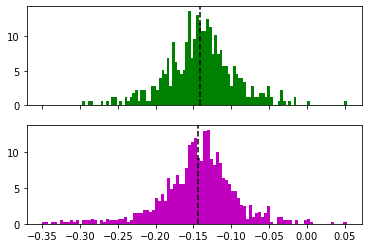

In [30]:
fig, axs = plt.subplots(nrows=2, sharex=True)
plt.sca(axs[0])
dist = coli_nosc_df.loc[high_mu_corr.index].NOSC
plt.hist(dist, color='g', density=True, bins=100)
plt.axvline(dist.mean(), ls='--', color='k')

plt.sca(axs[1])
mask = mu_correlation.max_rel_mass > 1e-4
dist = coli_nosc_df.loc[mu_correlation[mask].index].NOSC
plt.hist(dist, color='m', density=True, bins=100)
plt.axvline(dist.mean(), ls='--', color='k')
plt.show()

<AxesSubplot: xlabel='NOSC', ylabel='max_rel_mass'>

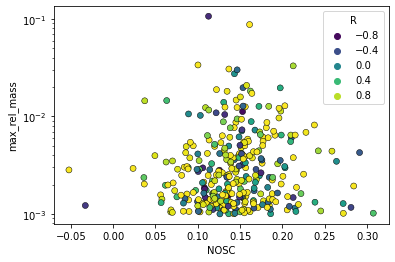

In [31]:
mask = mu_correlation.max_rel_mass > 1e-3
tmp = mu_correlation[mask]
plt.yscale('log')
sns.scatterplot(x=-tmp.NOSC, y=tmp.max_rel_mass, hue=tmp.R, palette='viridis', edgecolor='k', lw=0.5)


In [32]:
cols = 'gene_name,NOSC,description'.split(',')
coli_nosc_df.loc[high_mu_corr.index][cols].head(50)

,gene_name,NOSC,description
b_number,,,
b3339,tufA,-0.161181,Elongation factor Tu 1
b0957,ompA,-0.100218,Outer membrane protein A
b3340,fusA,-0.136727,Elongation factor G
b0014,dnaK,-0.122066,Chaperone protein DnaK
b0911,rpsA,-0.134606,30S ribosomal protein S1
b4143,groEL,-0.163886,Chaperonin GroEL
b2779,eno,-0.150334,Enolase
b1779,gapA,-0.145293,Glyceraldehyde-3-phosphate dehydrogenase A
b2926,pgk,-0.202848,Phosphoglycerate kinase
